In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


+ corrections for ellipticity, response and flux ratio 

$\frac{x}{1+x}=x-x^2$

$\frac{y}{1+x}=y(1-x)$

$\frac{a}{1+x}=a(1-x+x^2)$

$\frac{a^2}{(1+x)^2}=a^2(1-2x+3x^2)$

$\frac{(a+y)^2}{(1+x)^2}=a^2(1-2x+3x^2)+y^2+2ay(1-2x)$

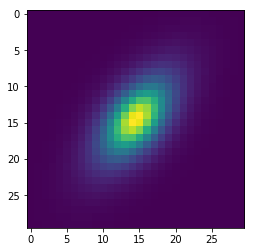

In [3]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
psfFWHM=0.60
scale=0.168
tog=False
igal=10
beta=0.75

hsmCat=pyfits.getdata('sim20210301/galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
rcut=rcutArray[igal]
    
beg=ngrid//2-rcut
end=beg+2*rcut
galImgAll=pyfits.getdata('sim20210301/galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
img=galImgAll[igal//nx*ngrid+beg:igal//nx*ngrid+end,igal%nx*ngrid+beg:igal%nx*ngrid+end]/10.
plt.imshow(img)

In [4]:
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
fpTask0=fpfsBase.fpfsTask(psfData,beta=beta)

a0=fpTask0.measure(img)
C=4
b0=fpfsBase.fpfsM2E(a0,C)
print(a0,a0.dtype.names)
print(b0,b0.dtype.names)

(10.3447971, 0.76471778, 3.09516119, 1.62472574) ('fpfs_M00', 'fpfs_M22c', 'fpfs_M22s', 'fpfs_M40')
[[(0.05330977, 0.21576891, 0.46477353, 0.72115325)]] ('fpfs_e1', 'fpfs_e2', 'fpfs_RE', 'fpfs_flux')


In [5]:
# Noise
corPre      =   'corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
variance    =   1e-4
ngrid=64

corIn=pyfits.getdata(corFname)*variance
corIn=np.pad(corIn,(23-32+rcut,22-32+rcut))

corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones(img.shape)))**2.)).real
corIn=corIn*corNum
powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
powModel=np.zeros((1,img.shape[0],img.shape[1]))
powModel[0]=powIn
#fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0],beta=beta)

In [6]:
if not os.path.isdir('test'):
    a=[]
    for i in range(0,40):
        noiAll=pyfits.getdata('sim20210301/noise/noi%04d.fits' %i)*np.sqrt(variance*100.)
        imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(ngal)]
        #plt.imshow(imgList[5])
        a.append(fpTask.measure(imgList))
        del noiAll,imgList
        gc.collect()
    a=np.vstack(a)

In [7]:
noiAll=pyfits.getdata('sim20210301/noise/noi%04d.fits' %i)*np.sqrt(variance*100.)
imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(4)]
aaaa=fpTask.measure(imgList)

In [8]:
print(np.average(a['fpfs_M00'])/np.average(a0['fpfs_M00'])-1)
print(np.average(a['fpfs_M22c'])/np.average(a0['fpfs_M22c'])-1)
print(np.average(a['fpfs_M40'])/np.average(a0['fpfs_M40'])-1)

-0.00038336462936172655
0.0016096080026426485
0.02572968487159799


In [9]:
print('variance of N00 from simulation and equation:')
print(np.var(a['fpfs_M00']),np.average(a['fpfs_N00N00']))
print('variance of N40 from simulation and equation:')
print(np.var(a['fpfs_M40']),np.average(a['fpfs_N40N40']))
print('variance of N22c from simulation and equation:')
print(np.var(a['fpfs_M22c']),np.average(a['fpfs_N22cN22c']))
print('variance of N22s from simulation and equation:')
print(np.var(a['fpfs_M22s']),np.average(a['fpfs_N22sN22s']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22c']*a['fpfs_M00'])-np.average(a['fpfs_M22c'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22c']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22s']*a['fpfs_M00'])-np.average(a['fpfs_M22s'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22s']))
print('cov of N40N00 from simulation and equation:')
print(np.average(a['fpfs_M40']*a['fpfs_M00'])-np.average(a['fpfs_M40'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N40']))

variance of N00 from simulation and equation:
1.368147986415445 1.3647075775784994
variance of N40 from simulation and equation:
2.3099689797219196 2.1761361212630095
variance of N22c from simulation and equation:
0.7240228675958698 0.7111342579538991
variance of N22s from simulation and equation:
0.8810721909109392 0.8797519269968569
cov of N22cN00 from simulation and equation:
0.10244239019365153 0.10066658463963575
cov of N22cN00 from simulation and equation:
0.3590743280946427 0.35912018100281695
cov of N40N00 from simulation and equation:
-0.10647826760386536 -0.13163108928929212


In [10]:
b=fpfsBase.fpfsM2E(a,C)

In [11]:
print(np.average(b['fpfs_e1']),np.average(b0['fpfs_e1']),np.average(b['fpfs_e1'])/np.average(b0['fpfs_e1'])-1)
print(np.average(b['fpfs_e2']),np.average(b0['fpfs_e2']))
print(np.average(b['fpfs_RE']),np.average(b0['fpfs_RE']),np.average(b['fpfs_RE'])/np.average(b0['fpfs_RE'])-1)
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])/np.average(b0['fpfs_e1'])*np.average(b0['fpfs_RE'])-1)

0.0532665476848516 0.053309766530847666 -0.0008107115976779822
0.215630097551524 0.21576890669732915
0.4655264389711335 0.4647735332941989 0.0016199409454280556
-0.0024267213977506863


In [12]:
ratio=a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.
e1=np.average((b['fpfs_e1']+a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1+ratio))
e2=np.average((b['fpfs_e2']+a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1+ratio))

In [13]:
print(e1-b0['fpfs_e1'][0])
print(e2-b0['fpfs_e2'][0])

[9.15322027e-05]
[0.00017718]


In [14]:
e1sq=np.average((b['fpfs_e1']**2.-a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e1']*a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
e2sq=np.average((b['fpfs_e2']**2.-a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e2']*a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
s0=np.average((a['fpfs_M00']/(a['fpfs_M00']+C)+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)/(1+ratio))
s4=np.average((a['fpfs_M40']/(a['fpfs_M00']+C)+a['fpfs_N00N40']/(a['fpfs_M00']+C)**2.)/(1+ratio))

In [15]:
print(e1sq-b0['fpfs_e1']**2.)
print(e2sq-b0['fpfs_e2']**2.)
print(s0-a0['fpfs_M00']/(a0['fpfs_M00']+C))
print(s4-a0['fpfs_M40']/(a0['fpfs_M00']+C))

[[0.00016326]]
[[0.00017554]]
-8.453116096340807e-05
0.002841998590956449


## $e$

In [16]:
print(np.average(b['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b['fpfs_e2']-b0['fpfs_e2']))

-4.321884599605928e-05
-0.00013880914580508818


In [17]:
print(np.average(a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.))
print(np.average(a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.))

0.0004892223413317902
0.0017488510467210915


In [18]:
print(np.average(a['fpfs_N00N00'])/np.average((a['fpfs_M00']+C)**2.)*b0['fpfs_e1'][0])
print(np.average(a['fpfs_N00N00'])/np.average((a['fpfs_M00']+C)**2.)*b0['fpfs_e2'][0])

[0.00035141]
[0.00142233]


## $e^2$

In [19]:
print(np.average(b['fpfs_e1']**2.)-np.average(b0['fpfs_e1']**2.))
print(np.average(b['fpfs_e2']**2.)-np.average(b0['fpfs_e2']**2.))

0.003463722065359308
0.00377069885459147


In [20]:
print(np.average(a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.),np.average(a['fpfs_N22cN22c']/(a0['fpfs_M00']+C)**2.))
print(np.average(a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.),np.average(a['fpfs_N22sN22s']/(a0['fpfs_M00']+C)**2.))

0.0034656130656895707 0.003455912843988432
0.004293975970698068 0.004275347376429034


In [21]:
print(4.*b0['fpfs_e1'][0]*np.average(a['fpfs_N00N22c']/(a0['fpfs_M00']+C)**2.))
print(4.*b0['fpfs_e2'][0]*np.average(a['fpfs_N00N22s']/(a0['fpfs_M00']+C)**2.))

[0.00010432]
[0.00150626]


## $\frac{M_{00}}{M_{00}+C}$

In [22]:
print(np.average(a['fpfs_M00']/(a['fpfs_M00']+C)),np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(np.average(a['fpfs_M00']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))

0.7192089636412157 0.7211532535088573
-0.0019442898676416132


In [23]:
print(np.average(a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.))

0.0066422378385686265


In [24]:
print(np.average(a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)*a0['fpfs_M00'])

0.005060905857143972


## $\frac{M_{40}}{M_{00}+C}$

In [25]:
print(np.average(a['fpfs_M40']/(a['fpfs_M00']+C)),np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print(np.average(a['fpfs_M40']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))

0.11748773322987274 0.11326237159707193
0.004225361632800809


In [27]:
print(np.average(a['fpfs_N00N40'])/np.average((a['fpfs_M00']+C)**2.))

-0.000635814239158818


In [28]:
len(a)

400000